In [1]:
"""Does statistical analysis"""
from typing import List, Tuple
import datetime
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype
import numpy as np
import time_series_correlation
#Open charts in new windows
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter #To avoid scientific notation

COMMENTS_DATA = "wallstreetbets-posts-and-comments-for-august-2021-comments.csv"
STOCK_DATA = ""

/tmp/ipykernel_23279/2631808833.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_comments():
    """Returns a dataframe of the commment table. It has the timestamp, comment body and sentiment scores.
    Records without a """
    df = pd.read_csv("wallstreetbets-posts-and-comments-for-august-2021-comments 1.csv")
    df['datetime'] = pd.to_datetime(df.created_utc, unit='s').dt.tz_localize('UTC') #get timestamps
    df.set_index('datetime', inplace=True)
    df = df[['body', 'sentiment']] #pick certain columns
    df =  df[df.sentiment.notna()] #extract rows with existing sentiment scores
    
    gme_mentions = df.body.str.contains("GME", case=False)
    gamestop_mentions = df.body.str.contains("gamestop", case=False)
    return df[gamestop_mentions | gme_mentions]

def get_sentiment() -> pd.Series:
    """Returns a series object that contains the sentiment of each comment"""
    return get_comments().sentiment

def chat_velocity(comments : pd.DataFrame) -> pd.Series:
    """Group comment count into 5min intervals, returns a Series object"""
    return get_sentiment().resample('5min').size()

def stock_data() -> pd.DataFrame:
    df = pd.read_csv("alphavantage_data_GME_2021-08.csv")
    df['datetime'] = pd.to_datetime(df.timestamp)
    return df.set_index('datetime')

def get_stock_price() -> pd.Series:
    """Returns a series object for the opening price of the stock data"""
    return stock_data().open

def get_stock_volume() -> pd.Series:
    """Returns a series object for the traded volume of the stock"""
    return stock_data().volume


In [3]:

def log_normal(series : pd.Series) -> pd.Series:
    """Performs log(x_n+1/x_n) on each item"""
    k = series.pct_change(1)
    k.apply(lambda x : np.log(x+1))
    return k

In [4]:
def plotTwoSeries(red : pd.Series, blue : pd.Series) -> None:
    """Plots both the given series. Both series need to have an datetime index"""
    fig, red_ax = plt.subplots()
    blue_ax = red_ax.twinx()

    plt.ticklabel_format(style='plain')
    red_plot, = red_ax.plot(red, color='red', label=red.name)
    blue_plot, = blue_ax.plot(blue, color='blue', label=blue.name)

    red_ax.xlabel = 'Time'
    red_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True)) #TODO: Add a y-axis limit at 0?
    blue_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    red_ax.set(ylabel=red.name)
    blue_ax.set(ylabel=blue.name)

    fig.autofmt_xdate(bottom=0.2, rotation=-30, ha='left')
    plt.title(f"{red.name} vs {blue.name}")
    plt.legend(handles=[red_plot, blue_plot])
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'wallstreetbets-posts-and-comments-for-august-2021-comments 1.csv'

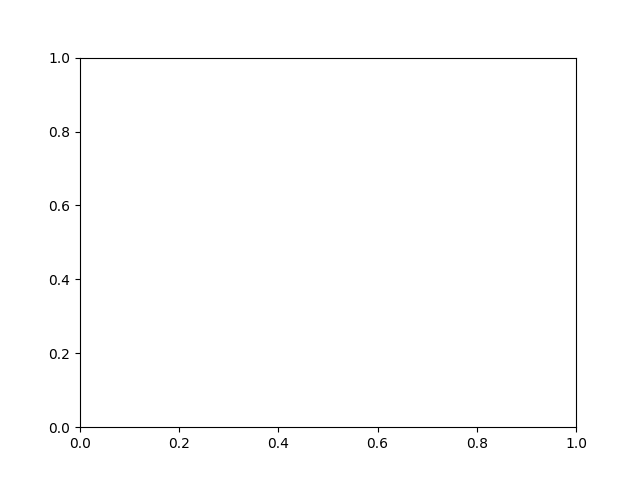

In [5]:
#Sentiment of each comment and  market price against time, in August 2021
fig, comments_ax = plt.subplots()
sentiment = get_sentiment()
#print(get_sentiment().columns)
comments_ax.scatter(sentiment.index,sentiment.values)#,x='datetime', y='values')
stocks_ax = comments_ax.twinx()
change_ax = stocks_ax.twinx()
prices = get_stock_price()
stocks_ax.plot(prices, color='tab:red')
logged = log_normal(prices)
change_ax.plot(logged, color ='tab:green')
plt.show()

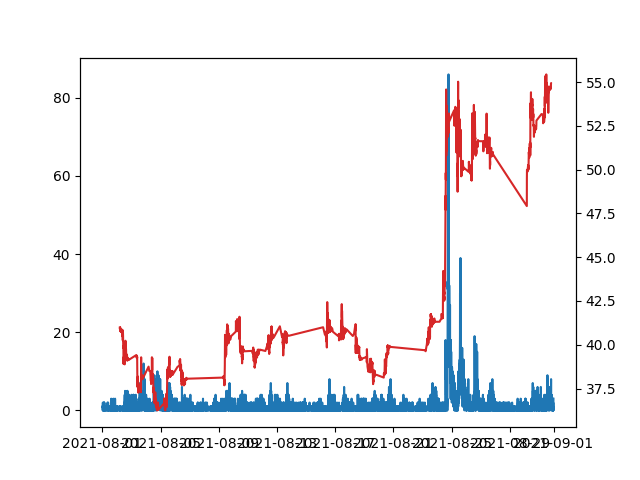

In [ ]:
#Plot comment frequency against market price, in August 2021

velocity : pd.Series = chat_velocity(time_series_correlation.get_market_sentiment()) 
stocks : pd.DataFrame = get_stock_price()
fig, comments_ax = plt.subplots()
comments_ax.plot(velocity)
stocks_ax = comments_ax.twinx()
stocks_ax.plot(stocks, color='tab:red')
plt.show()

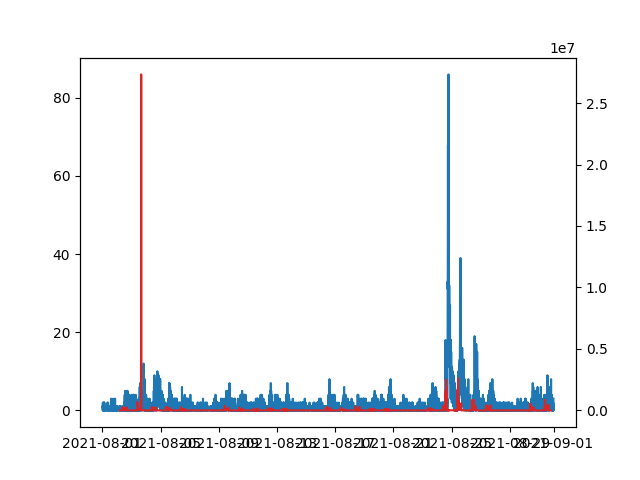

In [ ]:
#Plot chat velocity against traded volume, in August 2021
plotTwoSeries(chat_velocity(get_comments()), get_stock_volume())